In [2]:
import numpy as np
import numpy.random as npr
import random
import matplotlib.pyplot as plt
from IPython.display import display, Audio
import torch as torch

import torchvision as tv
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split, KFold
import sys
import torchvision.models as models
from sklearn import svm

In [3]:
class Feature_Dataset(Dataset):
    def __init__(self, data, labels):
        
        data = torch.from_numpy(data)
        labels = torch.from_numpy(labels)
        
        self.data = data
        self.labels = labels
        
    def __len__(self):
        
        return(len(self.labels))
    
    def __getitem__(self, idx):
        
        sample = dict()
        sample['index'] = idx
        sample['data'] = self.data[idx]
        sample['label'] = self.labels[idx]
        
        return sample

In [4]:
features = np.load('../input/zca-spectrograms/ZCA_features.npy')
labels_features = np.load('../input/zca-spectrograms/labels_training.npy')
x_train, x_test, y_train, y_test = train_test_split(features, labels_features, train_size=0.8)

features = None
labels_features=None

extra_features = np.load('../input/zca-spectrograms/extra_ZCA_features_1(2).npy', allow_pickle=True)
all_features = np.vstack((x_train, extra_features))
extra_features = None
x_train = None

extra_features_2 = np.load('../input/zca-spectrograms/extra_ZCA_features_2.npy', allow_pickle=True)
all_features = np.vstack((all_features, extra_features_2))
extra_features_2 = None

extra_features_3 = np.load('../input/zca-spectrograms/extra_ZCA_features_3.npy', allow_pickle=True)
all_features = np.vstack((all_features, extra_features_3))
extra_features_3 = None

labels_extra_features = np.load('../input/zca-spectrograms/labels_extra1.npy')
all_labels = np.append(y_train, labels_extra_features)
labels_extra_features = None
y_train = None

labels_extra_features_2 = np.load('../input/zca-spectrograms/labels_extra2.npy')
all_labels = np.append(all_labels, labels_extra_features_2)
labels_extra_features_3 = None

labels_extra_features_3 = np.load('../input/zca-spectrograms/labels_extra3.npy')
all_labels = np.append(all_labels, labels_extra_features_3)
labels_extra_features_3 = None

In [5]:
batch=24
criterion=nn.CrossEntropyLoss()

In [6]:
training_dataset = Feature_Dataset(all_features, all_labels)
test_dataset = Feature_Dataset(x_test, y_test)

In [7]:
x_test = None
y_test = None
all_features = None
all_labels = None

In [8]:
net = models.densenet161(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


In [9]:
num_classes = 8

# DENSENET 161
net.classifier = nn.Linear(2208, num_classes)
net.to(torch.device("cuda:0"));

In [10]:
training_loader = DataLoader(training_dataset, batch_size=batch, shuffle=True)
total_step = len(training_loader)

loss_list = []
acc_list = []
num_epochs = 60
test_accuracies, learning_rates = [], []

for learning_rate in [1e-4]:

    optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate, weight_decay=1e-3)
    training_accuracies = []

    for epoch in range(num_epochs):
        for idx, data in enumerate(training_loader):
            images, labels = data['data'], data['label']
            labels -= 1

            outputs = net(images.type(torch.cuda.FloatTensor))
            loss = criterion(outputs, labels.type(torch.cuda.LongTensor))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels.type(torch.cuda.LongTensor)).sum().item()
            acc_list.append(correct/ total)

            
        print('Epoch [{}/{}], Step[{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, idx +
                      1, total_step, loss.item(), (correct/total)*100))
        training_accuracies.append(np.average(acc_list))
        acc_list = []
        if epoch % 20 == 0:
            learning_rate/=10
            optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate, weight_decay=1e-3)

        #validation stage
        test_loader  = DataLoader(test_dataset, batch_size=batch, shuffle=True)
        test_acc = []
        for idx, data in enumerate(test_loader):
            images, labels = data['data'], data['label']
            labels -= 1
            outputs = net(images.type(torch.cuda.FloatTensor))
            loss = criterion(outputs, labels.type(torch.cuda.LongTensor))
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels.type(torch.cuda.LongTensor)).sum().item()
            test_acc.append(correct/ total)

        test_accuracies.append(np.average(test_acc))
        print('> Epoch [{}/{}], Test Loss: {:.4f}, Test Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs,
                          loss.item(), (test_accuracies[-1])*100))

        
        learning_rates.append(learning_rate)

Epoch [1/60], Step[80/80], Loss: 0.9920, Accuracy: 70.83%
> Epoch [1/60], Test Loss: 1.4375, Test Accuracy: 61.88%
Epoch [2/60], Step[80/80], Loss: 0.4981, Accuracy: 83.33%
> Epoch [2/60], Test Loss: 0.5437, Test Accuracy: 73.12%
Epoch [3/60], Step[80/80], Loss: 0.0870, Accuracy: 100.00%
> Epoch [3/60], Test Loss: 0.3653, Test Accuracy: 73.33%
Epoch [4/60], Step[80/80], Loss: 0.0218, Accuracy: 100.00%
> Epoch [4/60], Test Loss: 0.7417, Test Accuracy: 72.92%
Epoch [5/60], Step[80/80], Loss: 0.0123, Accuracy: 100.00%
> Epoch [5/60], Test Loss: 0.8678, Test Accuracy: 74.79%
Epoch [6/60], Step[80/80], Loss: 0.1467, Accuracy: 95.83%
> Epoch [6/60], Test Loss: 0.3867, Test Accuracy: 73.33%
Epoch [7/60], Step[80/80], Loss: 0.1989, Accuracy: 95.83%
> Epoch [7/60], Test Loss: 0.4633, Test Accuracy: 70.42%
Epoch [8/60], Step[80/80], Loss: 0.1207, Accuracy: 95.83%
> Epoch [8/60], Test Loss: 0.7982, Test Accuracy: 72.08%
Epoch [9/60], Step[80/80], Loss: 0.0887, Accuracy: 95.83%
> Epoch [9/60], Tes

In [12]:
training_accuracies_4 = training_accuracies
torch.save(net, f='/kaggle/working/solo_densenet_3.pt')

In [20]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    cm = cm.detach().numpy()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')




Normalized confusion matrix
[[0.69090909 0.23636364 0.05454545 0.01818182 0.         0.
  0.         0.        ]
 [0.09433962 0.77358491 0.05660377 0.01886792 0.01886792 0.01886792
  0.         0.01886792]
 [0.03508772 0.01754386 0.78947368 0.03508772 0.07017544 0.01754386
  0.01754386 0.01754386]
 [0.         0.01612903 0.06451613 0.85483871 0.01612903 0.03225806
  0.01612903 0.        ]
 [0.         0.01612903 0.03225806 0.01612903 0.85483871 0.03225806
  0.03225806 0.01612903]
 [0.04918033 0.03278689 0.06557377 0.03278689 0.04918033 0.75409836
  0.01639344 0.        ]
 [0.         0.         0.01492537 0.         0.04477612 0.
  0.94029851 0.        ]
 [0.         0.         0.07936508 0.         0.         0.01587302
  0.         0.9047619 ]]


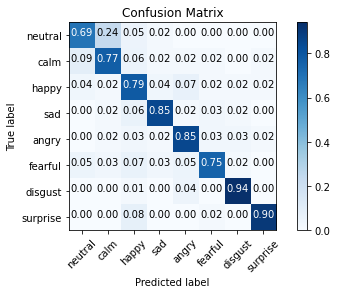

In [21]:
classes = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprise']
plot_confusion_matrix(cmt, classes, normalize=True)

49.5